<a href="https://colab.research.google.com/github/eyobedb/Multimodal-papaya-disease-classification-Leveraging-Computer-vision-and-NLP/blob/main/Multimodal_Resnet50_GPT2_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2Model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
data_dir_train = "/content/drive/MyDrive/Dataset/Train"
data_dir_val = "/content/drive/MyDrive/Dataset/Validation"
data_dir_test = "/content/drive/MyDrive/Dataset/Test"

In [4]:
img_size = 128
batch_size = 16


In [5]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [6]:
train_dataset = datasets.ImageFolder(data_dir_train, transform=transform)
val_dataset = datasets.ImageFolder(data_dir_val, transform=transform)
test_dataset = datasets.ImageFolder(data_dir_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_dataset.classes)
print(f"Classes: {train_dataset.classes}")

Classes: ['Black_spot_papaya', 'Healthy_papaya', 'Powdery_mildew', 'Ring_spot_papaya']


In [7]:
print("\n🔹 Loading GPT-2...")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
gpt2 = GPT2Model.from_pretrained("gpt2").to(device)
gpt2.eval()


🔹 Loading GPT-2...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [8]:
class_descriptions = {
    "Black_spot_papaya": "Leaves covered with black spots indicating black spot infection.",
    "Powdery_mildew": "Papaya leaves showing powdery mildew infection typical of powdery disease.",
    "Ring_spot_papaya": "Ring spot disease on papaya leaves indicating ring spot infection.",
    "Healthy_papaya": "Healthy Papaya leaf with no visible signs of disease or damage."
}

In [9]:
# Compute GPT-2 embeddings for each class
text_features = {}
with torch.no_grad():
    for cls, desc in class_descriptions.items():
        inputs = tokenizer(desc, return_tensors="pt", padding=True, truncation=True).to(device)
        outputs = gpt2(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1)
        text_features[cls] = emb.squeeze().cpu().numpy()

text_dim = emb.shape[-1]
print("Text feature dimension:", text_dim)

Text feature dimension: 768


In [10]:
# Map text embeddings to each image in the dataset
def get_text_features_for_batch(labels):
    features = []
    for lbl in labels:
        cls_name = train_dataset.classes[lbl]
        features.append(text_features[cls_name])
    return torch.tensor(features, dtype=torch.float32)


# ------------------------------------------------------------
# 4. Define Multimodal Model
# ------------------------------------------------------------

In [11]:
class MultimodalModel(nn.Module):
    def __init__(self, num_classes, text_dim=768):
        super(MultimodalModel, self).__init__()
        # Image Encoder: ResNet50
        self.resnet = models.resnet50(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False  # Freeze ResNet
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 512)

        # Text Encoder
        self.text_fc = nn.Linear(text_dim, 512)

        # Fusion + Classifier
        self.fc1 = nn.Linear(1024, 256)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, img, txt):
        img_feat = self.resnet(img)
        txt_feat = torch.relu(self.text_fc(txt))
        combined = torch.cat((img_feat, txt_feat), dim=1)
        x = torch.relu(self.fc1(combined))
        x = self.dropout(x)
        return self.fc2(x)

In [12]:
model = MultimodalModel(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 267MB/s]


# ------------------------------------------------------------
# 5. Training Loop
# ------------------------------------------------------------

In [13]:
def train_model(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)
            text_feats = get_text_features_for_batch(labels).to(device)

            optimizer.zero_grad()
            outputs = model(imgs, text_feats)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {acc*100:.2f}%")

        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                text_feats = get_text_features_for_batch(labels).to(device)
                outputs = model(imgs, text_feats)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_acc = val_correct / val_total
        print(f"✅ Validation Accuracy: {val_acc*100:.2f}%\n")

In [15]:
train_model(model, train_loader, val_loader, epochs=10)

Epoch 1/10: 100%|██████████| 360/360 [38:24<00:00,  6.40s/it]


Train Loss: 0.1738 | Train Acc: 96.86%
✅ Validation Accuracy: 100.00%



Epoch 2/10: 100%|██████████| 360/360 [05:27<00:00,  1.10it/s]


Train Loss: 0.0127 | Train Acc: 99.97%
✅ Validation Accuracy: 100.00%



Epoch 3/10: 100%|██████████| 360/360 [05:27<00:00,  1.10it/s]


Train Loss: 0.0034 | Train Acc: 100.00%
✅ Validation Accuracy: 100.00%



Epoch 4/10: 100%|██████████| 360/360 [05:27<00:00,  1.10it/s]


Train Loss: 0.0014 | Train Acc: 100.00%
✅ Validation Accuracy: 100.00%



Epoch 5/10: 100%|██████████| 360/360 [05:27<00:00,  1.10it/s]


Train Loss: 0.0009 | Train Acc: 100.00%
✅ Validation Accuracy: 100.00%



Epoch 6/10: 100%|██████████| 360/360 [05:28<00:00,  1.10it/s]


Train Loss: 0.0005 | Train Acc: 100.00%
✅ Validation Accuracy: 100.00%



Epoch 7/10: 100%|██████████| 360/360 [05:29<00:00,  1.09it/s]


Train Loss: 0.0003 | Train Acc: 100.00%
✅ Validation Accuracy: 100.00%



Epoch 8/10: 100%|██████████| 360/360 [05:28<00:00,  1.10it/s]


Train Loss: 0.0002 | Train Acc: 100.00%
✅ Validation Accuracy: 100.00%



Epoch 9/10: 100%|██████████| 360/360 [05:27<00:00,  1.10it/s]


Train Loss: 0.0002 | Train Acc: 100.00%
✅ Validation Accuracy: 100.00%



Epoch 10/10: 100%|██████████| 360/360 [05:31<00:00,  1.09it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
✅ Validation Accuracy: 100.00%



In [17]:
print("\n🔹 Evaluating on test set...")
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        text_feats = get_text_features_for_batch(labels).to(device)
        outputs = model(imgs, text_feats)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


🔹 Evaluating on test set...


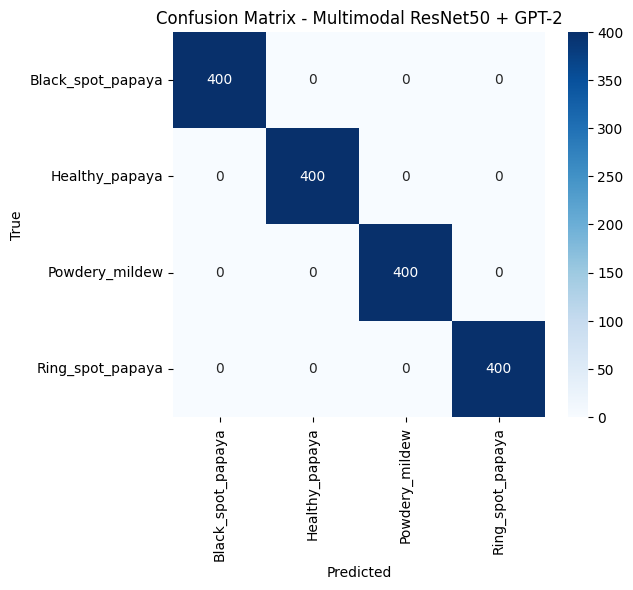

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title("Confusion Matrix - Multimodal ResNet50 + GPT-2")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [19]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))


Classification Report:
                   precision    recall  f1-score   support

Black_spot_papaya       1.00      1.00      1.00       400
   Healthy_papaya       1.00      1.00      1.00       400
   Powdery_mildew       1.00      1.00      1.00       400
 Ring_spot_papaya       1.00      1.00      1.00       400

         accuracy                           1.00      1600
        macro avg       1.00      1.00      1.00      1600
     weighted avg       1.00      1.00      1.00      1600

